### Import & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

In [3]:
from pipeline import run_pipeline

from data.db_utils import get_connection

from streamlit_app.plot_signals import plot_signals, plot_recent_signals

from backtest.backtest import PandasSignalData, run_backtest, print_bt_evals
from backtest.strategies import AtrDynamicStopStrategy, AtrLongOnlyStrategy

### Load data

In [4]:
DB_PATH = '../data/crypto_data.db'
conn = get_connection(DB_PATH)

symbol = 'ETHUSDT'

In [5]:
query = f""" 
    SELECT
    a.datetime, a.symbol, open, high, low, close, volume, final_signal
    FROM
    (SELECT * 
    FROM signals
    WHERE symbol='{symbol}'
    ORDER BY datetime DESC) a 
    LEFT JOIN kline b
    ON a.symbol=b.symbol and a.datetime = b.datetime
    """

In [6]:
df = pd.read_sql_query(
        query,
        conn,
        parse_dates=['datetime']
    ).sort_values('datetime').set_index('datetime')

### Visualize signals

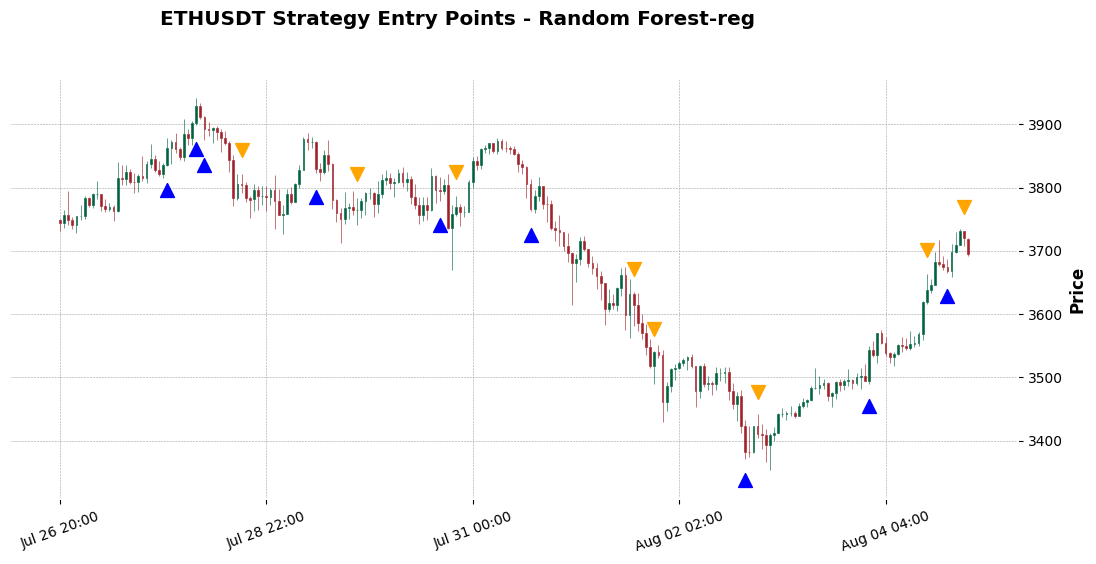

In [7]:
start_dt = '2025-07-20 00:00:00'
end_dt = '2025-08-05 00:00:00'

plot_signals(df=df, start=start_dt, end=end_dt, symbol=symbol, strategy_name='Random Forest-reg')

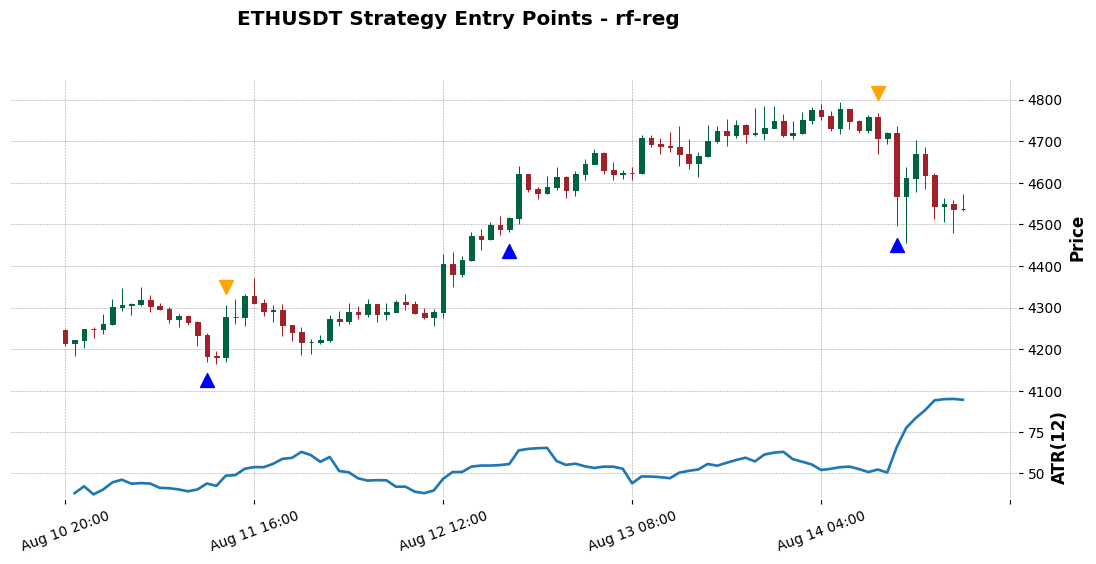

In [9]:
plot_recent_signals(limit=4*24)

### Run backtest

#### ATR dynamic

In [31]:
strategy_params = dict(
        atr_period=12,
        atr_tp_factor=1.5,
        atr_sl_factor=1.5,
        signal_column='final_signal'
    )

In [32]:
results = run_backtest(strategy_class=AtrDynamicStopStrategy,
             signals_df=df, 
             strategy_params=strategy_params,
             )

2025-07-27T22:00:00 - 开多仓 @ 3863.10 (TP=3910.43, SL=3815.77)
2025-07-28T05:00:00 - 多头止盈 @ 3910.43
2025-07-28T07:00:00 - 开多仓 @ 3892.01 (TP=3943.13, SL=3840.89)
2025-07-28T13:00:00 - 多头止损 @ 3840.89
2025-07-28T16:00:00 - 开空仓 @ 3804.54 (TP=3749.82, SL=3859.26)
2025-07-29T00:00:00 - 空头止盈 @ 3749.82
2025-07-29T10:00:00 - 开多仓 @ 3828.72 (TP=3885.06, SL=3772.38)
2025-07-29T14:00:00 - 多头止损 @ 3772.38
2025-07-29T20:00:00 - 开空仓 @ 3763.80 (TP=3702.22, SL=3825.38)
2025-07-30T03:00:00 - 空头止损 @ 3825.38
2025-07-30T16:00:00 - 开多仓 @ 3794.79 (TP=3853.84, SL=3735.74)
2025-07-30T18:00:00 - 多头止损 @ 3735.74
2025-07-30T20:00:00 - 开空仓 @ 3768.65 (TP=3699.90, SL=3837.40)
2025-07-31T00:00:00 - 空头止损 @ 3837.40
2025-07-31T14:00:00 - 开多仓 @ 3766.59 (TP=3814.44, SL=3718.74)
2025-07-31T16:00:00 - 多头止盈 @ 3814.44
2025-08-01T15:00:00 - 开空仓 @ 3614.49 (TP=3541.07, SL=3687.91)
2025-08-01T18:00:00 - 空头止盈 @ 3541.07
2025-08-01T20:00:00 - 开空仓 @ 3539.90 (TP=3466.38, SL=3613.42)
2025-08-01T22:00:00 - 空头止盈 @ 3466.38
2025-08-02T18:00:00 

In [33]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.18984458557429643
Max Drawdown: 6.77%
Total Return: 6.32%, Annual Return: 121.80%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 27, 'open': 0, 'closed': 27})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 3),
                                                     ('longest', 5)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 4)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      9081.020000000086),
                                                     ('average',
                                                      336.33407407407725)])),
                                   ('net',
      

#### ATR long only

In [34]:
strategy_params = dict(
        atr_period=12,
        atr_tp_factor=1.5,
        atr_sl_factor=1.5,
        signal_column='final_signal'
    )

In [35]:
results = run_backtest(strategy_class=AtrLongOnlyStrategy,
             signals_df=df, 
             strategy_params=strategy_params,
             )

2025-07-27T22:00:00 - Opening long position @ 3863.10 (TP=3910.43, SL=3815.77)
2025-07-28T05:00:00 - Taking profit @ 3910.43
2025-07-28T06:00:00 - Skipping trade with size 0 (possibly invalid)
2025-07-28T07:00:00 - Opening long position @ 3892.01 (TP=3943.13, SL=3840.89)
2025-07-28T13:00:00 - Stop loss @ 3840.89
2025-07-28T14:00:00 - Skipping trade with size 0 (possibly invalid)
2025-07-29T10:00:00 - Opening long position @ 3828.72 (TP=3885.06, SL=3772.38)
2025-07-29T14:00:00 - Stop loss @ 3772.38
2025-07-29T15:00:00 - Skipping trade with size 0 (possibly invalid)
2025-07-30T16:00:00 - Opening long position @ 3794.79 (TP=3853.84, SL=3735.74)
2025-07-30T18:00:00 - Stop loss @ 3735.74
2025-07-30T19:00:00 - Skipping trade with size 0 (possibly invalid)
2025-07-31T14:00:00 - Opening long position @ 3766.59 (TP=3814.44, SL=3718.74)
2025-07-31T16:00:00 - Taking profit @ 3814.44
2025-07-31T17:00:00 - Skipping trade with size 0 (possibly invalid)
2025-08-02T18:00:00 - Opening long position @ 3

In [36]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.39544648915090763
Max Drawdown: 4.33%
Total Return: 12.32%, Annual Return: 372.22%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 16, 'open': 0, 'closed': 16})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 3),
                                                     ('longest', 4)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 3)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      14740.39000000001),
                                                     ('average',
                                                      921.2743750000006)])),
                                   ('net',
      